## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

import sys
sys.path.append('hifigan/')
import numpy as np
import torch
import librosa
import librosa.display
import math
import json
import os

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from text.cleaners import transliteration_ua_cleaners, english_cleaners, transliteration_cleaners
from text.rudict import RuDict


from hifigan.meldataset import MAX_WAV_VALUE
from hifigan.models import Generator
from hifigan.env import AttrDict

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')
    plt.savefig('out.png')
    ipd.display(ipd.Image('out.png'))

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
checkpoint_path = "outdir/checkpoint_500"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

In [5]:

text = "po dannym telekanala futbol, eks igrok sbornoi ukra<ny evgenii selezn$v nakanune igry za kolos posidel s drugim eks igrok*m.".lower()
print(transliteration_cleaners(text))
sequence = np.array(text_to_sequence(text, ['transliteration_cleaners']))[None, :]
print(sequence)
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

po dannym telekanala futbol, eks igrok sbornoi ukra<ny evgenii selezn$v nakanune igry za kolos posidel s drugim eks igrok*m.
[[53 52 11 41 38 51 51 62 50 11 57 42 49 42 48 38 51 38 49 38 11 43 58 57
  39 52 49  6 11 42 48 56 11 46 44 55 52 48 11 56 39 52 55 51 52 46 11 58
  48 55 38 71 51 62 11 42 59 44 42 51 46 46 11 56 42 49 42 63 51 69 59 11
  51 38 48 38 51 58 51 42 11 46 44 55 62 11 63 38 11 48 52 49 52 56 11 53
  52 56 46 41 42 49 11 56 11 41 55 58 44 46 50 11 42 48 56 11 46 44 55 52
  48 68 50  7]]


In [6]:
%%time
# np.random.seed(16)
_, mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence,seed=42)

NameError: name 'decoder_output' is not defined

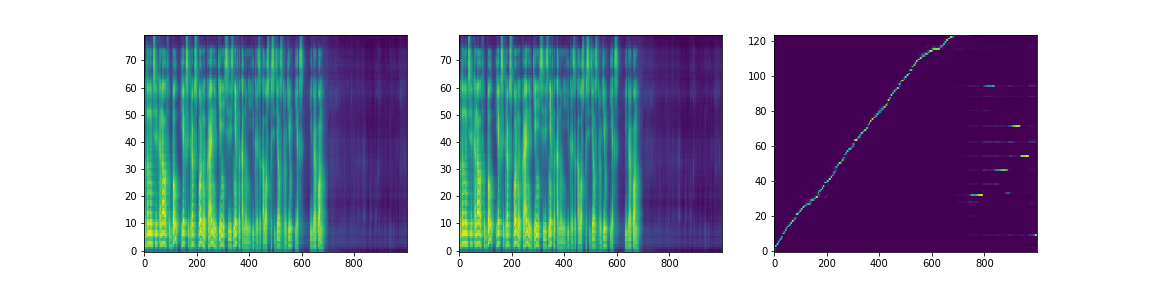

In [219]:
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [216]:
def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

def inference(mel):
    device = torch.device('cuda')
    with open('hifigan/config.json') as fp:
        json_config = json.load(fp)
        h = AttrDict(json_config)
    generator = Generator(h).to(device)

    state_dict_g = load_checkpoint("hifigan/g_02500000", device)
    generator.load_state_dict(state_dict_g['generator'])

    generator.eval()
    generator.remove_weight_norm()
    with torch.no_grad():
        y_g_hat = generator(mel)
        audio = y_g_hat.squeeze()
        audio = audio * MAX_WAV_VALUE
        audio = audio.detach().cpu().numpy()#.astype('int16')

        return audio
    
mel = mel_outputs_postnet.type(torch.float32)
audio = inference(mel)
ipd.Audio(audio, rate=hparams.sampling_rate)

Loading 'hifigan/g_02500000'
Complete.
Removing weight norm...


In [220]:
def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

def inference(mel):
    device = torch.device('cuda')
    with open('hifigan/config.json') as fp:
        json_config = json.load(fp)
        h = AttrDict(json_config)
    generator = Generator(h).to(device)

    state_dict_g = load_checkpoint("hifigan/g_02500000", device)
    generator.load_state_dict(state_dict_g['generator'])

    generator.eval()
    generator.remove_weight_norm()
    with torch.no_grad():
        y_g_hat = generator(mel)
        audio = y_g_hat.squeeze()
        audio = audio * MAX_WAV_VALUE
        audio = audio.detach().cpu().numpy()#.astype('int16')

        return audio
    
mel = mel_outputs_postnet.type(torch.float32)
audio = inference(mel)
ipd.Audio(audio, rate=hparams.sampling_rate)

Loading 'hifigan/g_02500000'
Complete.
Removing weight norm...
